# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

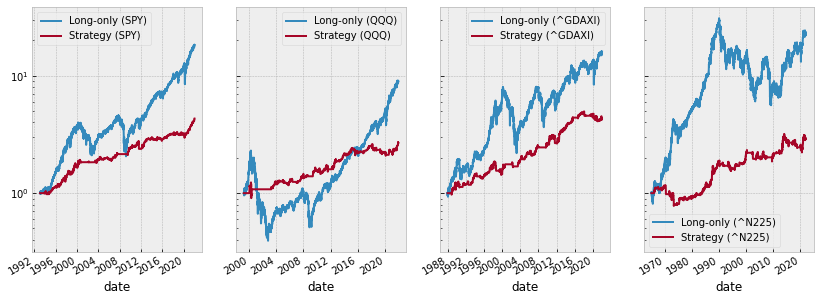

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.100757,0.050651,0.096116,0.043120,0.081535,0.042764,0.056632,0.019293
Annualised vol,0.187231,0.073444,0.275947,0.101077,0.222025,0.082820,0.201709,0.075274
Sharpe ratio,0.538141,0.689656,0.348314,0.426608,0.367232,0.516350,0.280762,0.256300
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.182565,0.359849,0.115853,0.162118,0.112176,0.182781,0.069172,0.057574
Skewness,-0.056146,-0.820782,0.230075,1.634716,-0.134186,-1.846530,-0.194105,-3.336810
Kurtosis,12.135982,39.950169,7.221155,71.778607,6.549293,68.128327,8.945853,120.908986
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081136,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


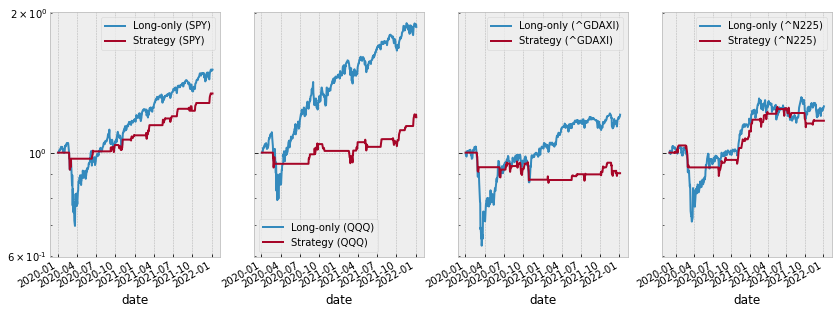

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

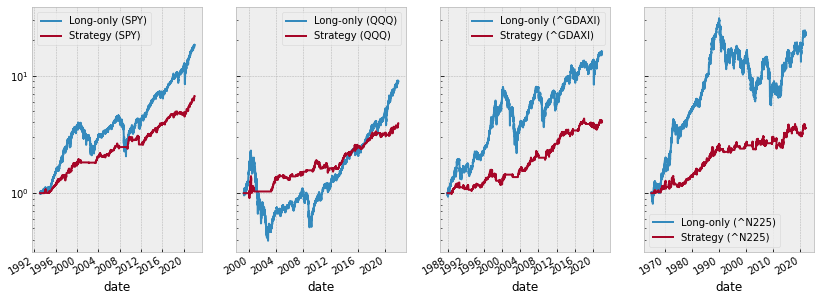

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.100757,0.065949,0.096116,0.059924,0.081535,0.041239,0.056632,0.022984
Annualised vol,0.187231,0.082925,0.275947,0.115240,0.222025,0.089320,0.201709,0.087171
Sharpe ratio,0.538141,0.795289,0.348314,0.519995,0.367232,0.461706,0.280762,0.263662
Max drawdown,0.551894,0.163106,0.829639,0.282276,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.182565,0.404334,0.115853,0.212289,0.112176,0.160617,0.069172,0.104941
Skewness,-0.056146,-0.591508,0.230075,0.803131,-0.134186,-0.219974,-0.194105,-2.475163
Kurtosis,12.135982,28.079901,7.221155,47.612922,6.549293,16.115333,8.945853,82.715221
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081136,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


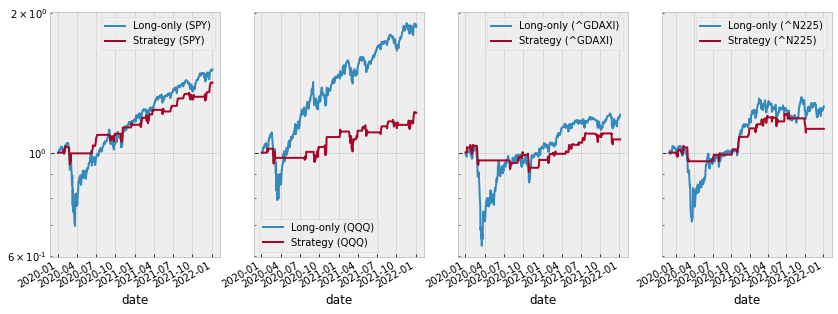

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

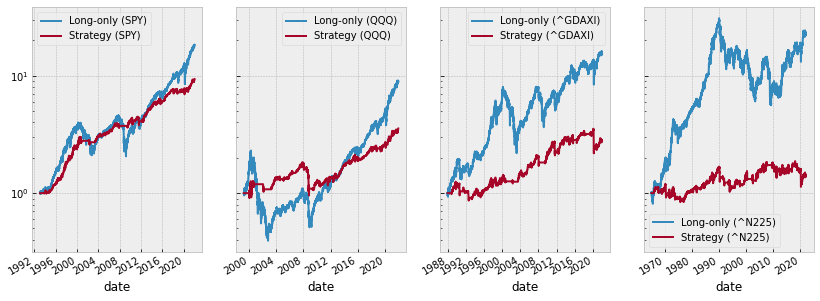

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.100757,0.077507,0.096116,0.055715,0.081535,0.030599,0.056632,0.006132
Annualised vol,0.187231,0.098518,0.275947,0.145948,0.222025,0.118774,0.201709,0.106474
Sharpe ratio,0.538141,0.786727,0.348314,0.381747,0.367232,0.257620,0.280762,0.057594
Max drawdown,0.551894,0.153225,0.829639,0.480136,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.182565,0.505836,0.115853,0.116040,0.112176,0.080060,0.069172,0.015489
Skewness,-0.056146,-0.293652,0.230075,0.660592,-0.134186,-1.202485,-0.194105,-1.634465
Kurtosis,12.135982,18.080561,7.221155,32.363714,6.549293,36.964895,8.945853,45.770810
Worst return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


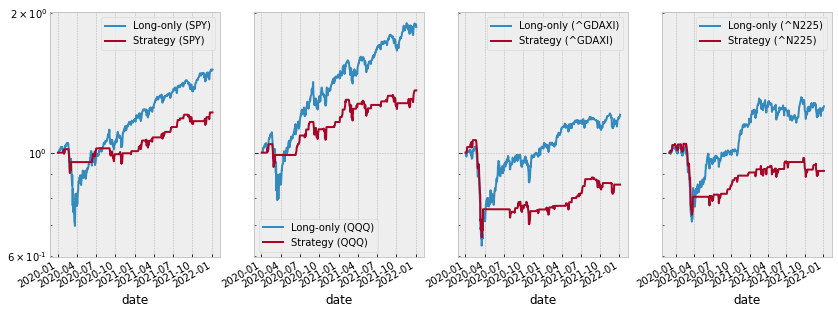

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

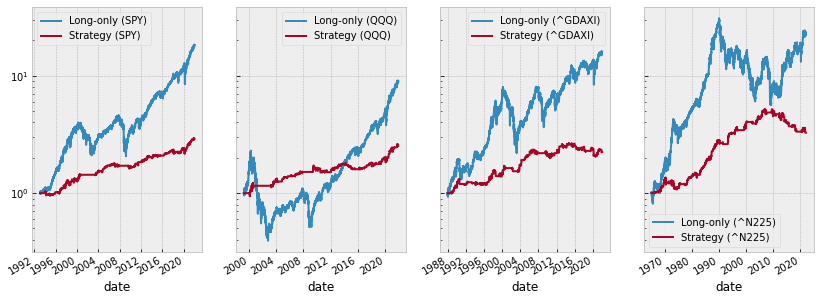

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.100757,0.036757,0.096116,0.040733,0.081535,0.023722,0.056632,0.021323
Annualised vol,0.187231,0.062842,0.275947,0.082867,0.222025,0.067070,0.201709,0.058761
Sharpe ratio,0.538141,0.584914,0.348314,0.491541,0.367232,0.353685,0.280762,0.362873
Max drawdown,0.551894,0.111611,0.829639,0.131617,0.726848,0.238856,0.818712,0.369951
Calmar ratio,0.182565,0.329333,0.115853,0.309477,0.112176,0.099313,0.069172,0.057637
Skewness,-0.056146,-0.782901,0.230075,0.425621,-0.134186,-0.274240,-0.194105,-1.794968
Kurtosis,12.135982,46.081424,7.221155,39.434631,6.549293,27.100063,8.945853,77.245026
Worst return,-0.109424,-0.072474,-0.119788,-0.057517,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.057517,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106266,-0.216097,-0.124379,-0.243342,-0.127345


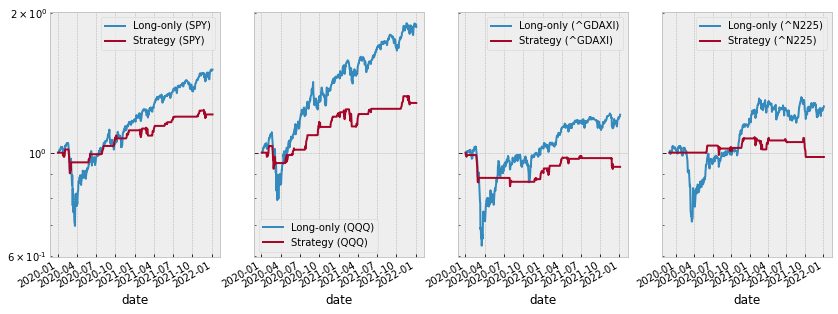

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 05-Jan-2022 07:05
